## Import Packages

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import collections
import pickle
import os
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import csv
from sklearn.model_selection import train_test_split
import time
from scipy.ndimage.measurements import label
from random import shuffle

%matplotlib inline
np.set_printoptions(threshold=np.nan)


## Load Images

#### GTI Vehicle Image Database, KITTI vision benchmark suite, Examples from Project Video


In [3]:
car_images = glob.glob('vehicles/*/*.png')
not_car_images = glob.glob('non-vehicles/*/*.png')
print(len(car_images),len(not_car_images))

8792 8968


#### Udacity dataset

In [4]:
samples = []
with open('./object-dataset/labels1.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
shuffle(samples)

## Histogram of Oriented Gradients 

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
    return features

## Compressed Spatial Vector

In [6]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Return the feature vector
    return np.hstack((color1,color2,color3))

## Colour Histograms

In [7]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Read Image Loop

In [8]:
def dataset_one_loop(imgs,cspace,orient,pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins,hist_range):
    # Iterate through the list of images
    features = []
    #i=0
    for file in imgs:
        #i=0
        # Read in each one by one
        image = cv2.imread(file)
        single_feature = extract_features(image,cspace, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range)
        features.append(single_feature)
        #i+=1
        #if i ==50:
         #   break
    return np.array(features)

In [9]:
def dataset_two_loop(samples,cspace,orient,pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins, hist_range):
    # Iterate through the list of images
    features = []
    i=0
    for sample in samples:
        car = cv2.imread('./object-dataset/'+str(sample[0]))
        img_tosearch = car[int(sample[2]):int(sample[4]),int(sample[1]):int(sample[3]),:]
        image = cv2.resize(img_tosearch, (64,64))
        single_feature = extract_features(image,cspace, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, hist_range)
        features.append(single_feature)
        i+=1
        if i ==8000:
            break
    return np.array(features)

## Feature Extraction

In [10]:
def extract_features(image,cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32,32), hist_bins=32, hist_range=(0, 256)):
    combined_features = []
    # Iterate through the list of images
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    combined_features.append(spatial_features)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins)
    combined_features.append(hist_features)
    # Append the new feature vector to the features list
    combined_features.append(hog_features)
    #i += 1
        #if i == 5000:
        #    break
    # Return list of feature vectors
    return np.concatenate(combined_features)


## Declare Car/Non-Car Features 

In [11]:
car_features = dataset_one_loop(car_images, cspace='YCrCb', orient = 9, pix_per_cell = 8, cell_per_block = 2,hog_channel='ALL',spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
notcar_features = dataset_one_loop(not_car_images, cspace='YCrCb', orient = 9, pix_per_cell = 8, cell_per_block = 2,hog_channel='ALL',spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))
car_uda_features = dataset_two_loop(samples, cspace='YCrCb', orient = 9, pix_per_cell = 8, cell_per_block = 2,hog_channel='ALL',spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))


E:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Combine and Normalize Feature Vectors and Labels

(25760, 8460)


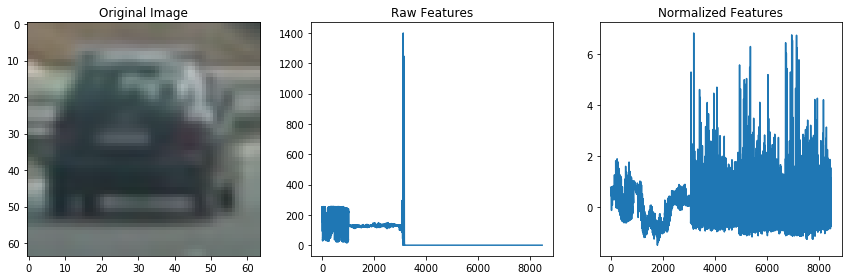

In [12]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    
    X = np.vstack((car_features, notcar_features, car_uda_features)).astype(np.float64)                        
    # Fit a per-column scaler
    print(X.shape)
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, 50)
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(car_images[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[20000])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    pickle.dump(X_scaler, open("x_scaler.p","wb"))
    
else: 
    print('Your function only returns empty feature vectors...')

#Define labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features)),np.ones(len(car_uda_features))))

## Split and Randomize 

In [13]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

## Training the Classifier

In [14]:
#print('Using:',orient,'orientations',pix_per_cell,
#    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 8460
43.85 Seconds to train SVC...
Test Accuracy of SVC =  0.979
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  1.  0.  1.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  1.  0.  1.  1.]
0.001 Seconds to predict 10 labels with SVC


## Save Model

In [45]:
filename = 'model.sav'
pickle.dump(svc, open(filename, 'wb'))

## Convert Colourspace

In [15]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'YCrCb2RGB':
        return cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if conv == 'RGB2BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)


## Perform Sub-Sampled Window Search and Draw Bounding Boxes

In [16]:
ystart = 400
ystop = 656
orient=9
pix_per_cell=8
cell_per_block=2
spatial_size=(32,32)
hist_bins=32
hist_range=(0, 256)

In [17]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, load_model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.asarray(img)
    img_tosearch = draw_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    #ctrans_tosearch = img_tosearch
    
    bbox_list=[]
    
    for scale in np.arange(1,2,0.25):
        if scale != 1:
            imshape = img_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell) + 1 # i.e. 2x2 blocks = 19 blocks
        nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
        nfeat_per_block = orient*cell_per_block**2 #squared for 2 dimensions: x and y

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell) + 1 # 7 blocks per window
        cells_per_step = 2  # Instead of overlap, define how many cells to step 
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step #steps taken by window
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):

                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=spatial_size)
                hist_features = color_hist(subimg, nbins=hist_bins)
                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.array(hog_features).reshape(1, -1))
                test_prediction = load_model.predict(test_features)
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    


                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                    bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bbox_list

## Plot Heat Map

In [18]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

## Apply Threshold on Heat Map

In [19]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

## Draw Labeled Boxes

In [20]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    drawn_img = np.copy(img)
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzerogrid = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzerogrid[0])
        nonzerox = np.array(nonzerogrid[1])
        # Define a bounding box based on min/max x and y
        bbox_final = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(drawn_img, bbox_final[0], bbox_final[1], (0,0,255), 6)
    # Return the image
    return drawn_img

## Video Pipeline Parameters

In [21]:
ystart = 400
ystop = 656
orient=9
pix_per_cell=8
cell_per_block=2
spatial_size=(32,32)
hist_bins=32
hist_range=(0, 256)

In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Heatmap Pipeline

In [22]:
def heatmap_search(img , hot_windows, threshold=5):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    heat = apply_threshold(heat,threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(img, labels)
    
    return draw_img , heatmap

## Convert Bounding Box 3D Tensor to Single 3D Vector

In [23]:
def Gather(self):
    bounds = np.asarray(self.boundbox)
    bounding = np.vstack(bounds)
    return bounding

## Average Heatmap Values

In [24]:
def Average(self):
    maps = np.asarray(self.heatmap)
    if len(maps)>0:
        avg=0
        for map in maps:
            avg +=map
        avg = avg / len(maps)
    else:
        avg = np.zeros_like(self[:,:,0]).astype(np.float)
    return avg

## Image Processing Pipeline

In [25]:
def Process_Image(file):
    image_find = np.copy(file)
    image_heat = np.copy(file)
    image_final = np.copy(file)
    out_img, bbox = find_cars(image_find, ystart, ystop, load_model, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if not bbox:
        heat_map.boundbox.append([((0,0),(0,0))])
    else:
        heat_map.boundbox.append(bbox)
    bboxes = Gather(heat_map)
    
    final,hmap = heatmap_search(image_heat, bboxes, threshold =45)
    heat_map.heatmap.append(hmap)
    
    avg_map = Average(heat_map)
    final_avg = apply_threshold(avg_map, 27)
    heatmap_final = np.clip(final_avg, 0, 255)
    labels_final = label(heatmap_final)
    draw_img_final = draw_labeled_bboxes(image_final, labels_final)
    
    return draw_img_final
 

## Bounding Box Classes

In [26]:
class Heat():
    def __init__(self, n=7):
        # number of previous frames to save heat map data from
        self.n = n
        # number of maps in buffer
        self.n_buffered = 0
        # was the map detected in the last iteration?
        self.first = False  
        # x values of the last n fits of the line
        self.heatmap = collections.deque([], maxlen=n)
        # y values of the last n fits of the line
        self.boundbox = collections.deque([], maxlen=3)

## Load Model

In [18]:
filename = 'model.sav'
load_model = pickle.load(open(filename, 'rb'))
X_scaler = pickle.load(open('x_scaler.p', 'rb'))

# Make Video

In [19]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def Video():
    white_output = 'test_videos_output/project3.mp4'
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip("project_video.mp4")
    white_clip = clip1.fl_image(Process_Image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(white_output, audio=False)

In [23]:
heat_map = Heat()
Video()

[MoviePy] >>>> Building video test_videos_output/project3.mp4
[MoviePy] Writing video test_videos_output/project3.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [48:54<00:02,  2.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project3.mp4 

Wall time: 48min 55s


---

## Analysis / Feature Inspection

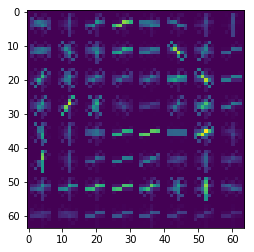

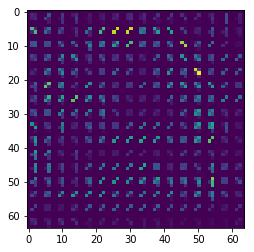

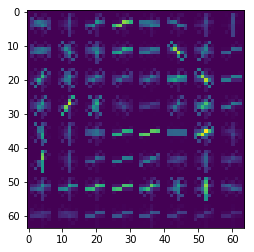

(1764,)
(8100,)
(2916,)


In [49]:
image = mpimg.imread(car_images[23])
spatial_img = cv2.resize(image[:,:,0],(32,32))
hog_hist = get_hog_features(image[:,:,0], orient = 9, pix_per_cell = 8, cell_per_block=2, vis=True)
hog_hist1 = get_hog_features(image[:,:,0], orient = 9, pix_per_cell = 4, cell_per_block=2, vis=True)
hog_hist2 = get_hog_features(image[:,:,0], orient = 9, pix_per_cell = 8, cell_per_block=6, vis=True)
plt.imshow(hog_hist[1])
plt.show()
plt.imshow(hog_hist1[1])
plt.show()
plt.imshow(hog_hist2[1])
plt.show()

print(hog_hist[0].shape)
print(hog_hist1[0].shape)
print(hog_hist2[0].shape)


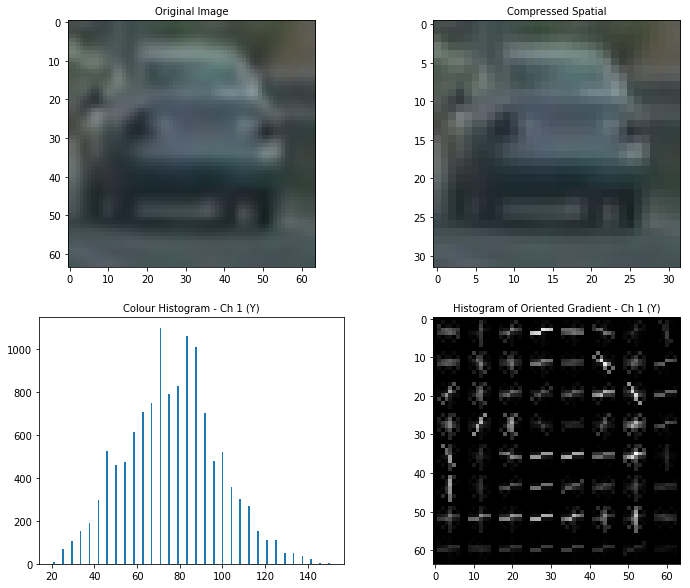

In [48]:
image = cv2.imread(car_images[23])
image1 = convert_color(image, conv='BGR2RGB')
spatial_img = cv2.resize(image,(32,32))
hog_hist = get_hog_features(image[:,:,0], orient = 9, pix_per_cell = 8, cell_per_block=2, vis=True)
color_hist,bins = np.histogram(image[:,:,], bins=32)

f,([ax1,ax2],[ax3,ax4]) = plt.subplots(2,2, figsize=(12,10), gridspec_kw={'hspace':0.2})

ax1.imshow(image1)
ax1.set_title('Original Image', fontsize=10)
spatial_img = convert_color(spatial_img, conv='BGR2RGB')
ax2.imshow(spatial_img)
ax2.set_title('Compressed Spatial', fontsize=10)
#hog_hist[1] = convert_color(hog_hist[1], conv='BGR2RGB')
ax4.imshow(hog_hist[1], cmap ='gray')
ax4.set_title('Histogram of Oriented Gradient - Ch 1 (Y)', fontsize=10)
center = (bins[:-1]+bins[1:])/2 #find point for each bin in bar graph to be centered around 
ax3.bar(center, color_hist)
ax3.set_title('Colour Histogram - Ch 1 (Y)', fontsize=10)

E:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


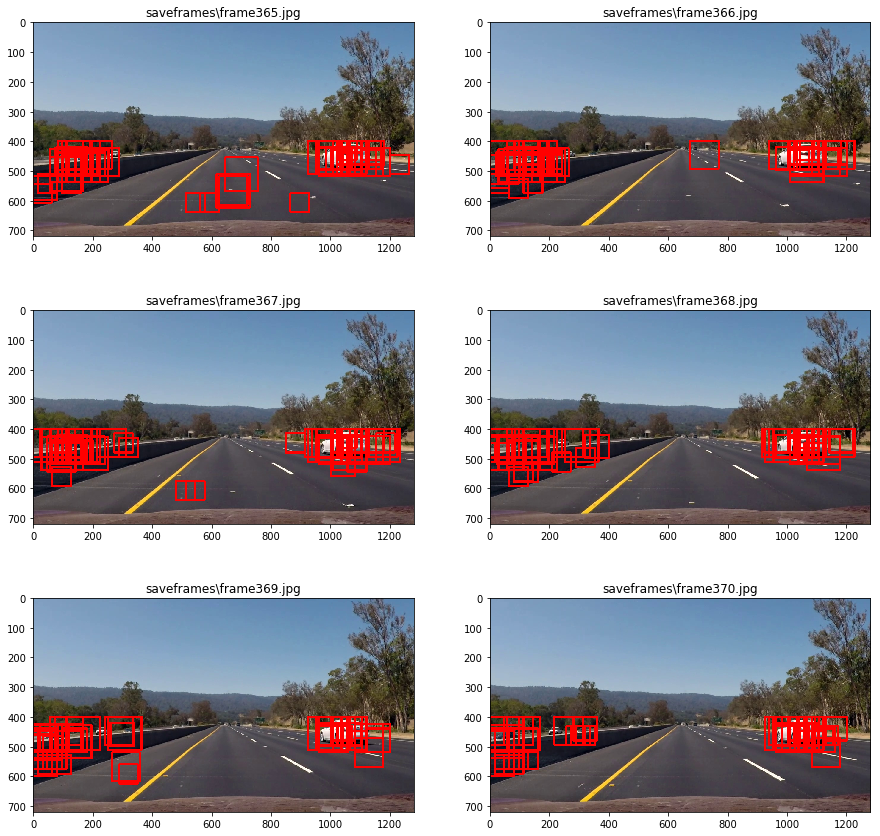

In [27]:
test_images = glob.glob('saveframes/*.jpg')
heat_map = Heat()
fig = plt.figure(figsize=(15,15))
i=1
for file in test_images:
    img = cv2.imread(str(file))
    image_find = np.copy(img)
    out_img, bbox = find_cars(image_find, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    if not bbox:
        heat_map.boundbox.append([((0,0),(0,0))])
    else:
        heat_map.boundbox.append(bbox)
    bboxes = Gather(heat_map)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,5)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    final = convert_color(out_img, conv='BGR2RGB')
    draw_img = draw_labeled_bboxes(img, labels)
    
    ax = fig.add_subplot(3, 2, i)
    ax.imshow(final)
    ax.set_title(str(file))
    i += 1
    

E:\Anaconda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


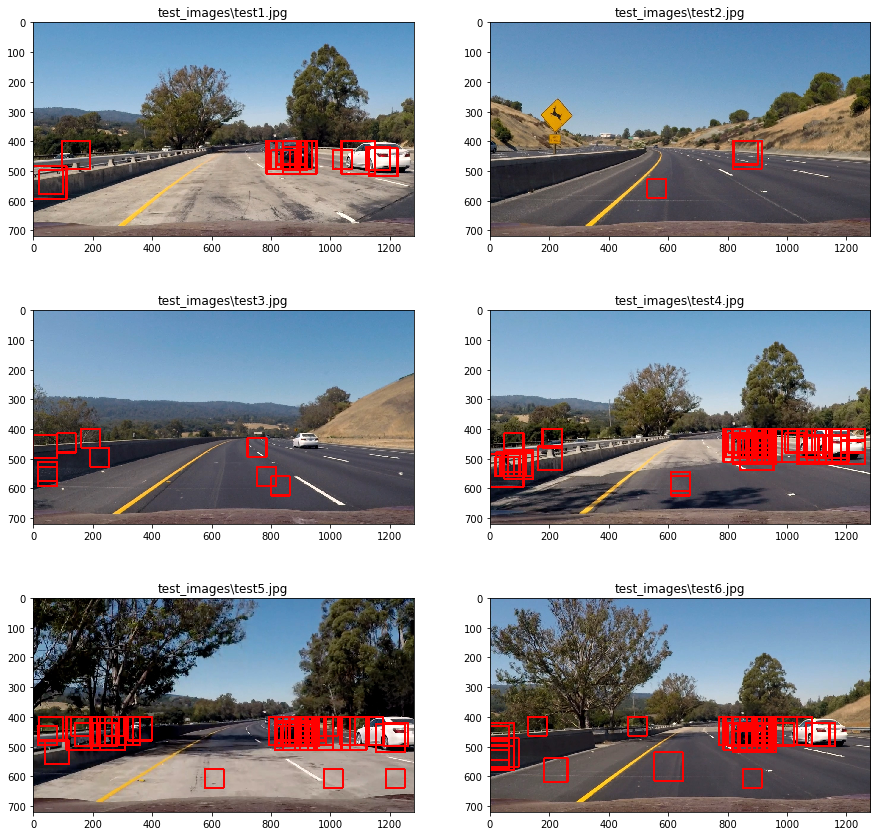

In [28]:
test_images = glob.glob('test_images/*.jpg')
heat_map = Heat()
#f,([ax1,ax2],[ax3,ax4],[ax5,ax6]) = plt.subplots(3,2, figsize=(24, 16), gridspec_kw={'hspace':0.1})
fig = plt.figure(figsize=(15,15))
i=1
for file in test_images:
    img = cv2.imread(str(file))
    image_find = np.copy(img)
    out_img, bbox = find_cars(image_find, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    if not bbox:
        heat_map.boundbox.append([((0,0),(0,0))])
    else:
        heat_map.boundbox.append(bbox)
    bboxes = Gather(heat_map)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,bbox)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    final = convert_color(out_img, conv='BGR2RGB')
    draw_img = draw_labeled_bboxes(img, labels)
    
    ax = fig.add_subplot(3, 2, i)
    ax.imshow(final)
    ax.set_title(str(file))
    i += 1
    
    #f,([ax1,ax2],[ax3,ax4],[ax5,ax6]) = plt.subplots(3,2, figsize=(24, 16), gridspec_kw={'hspace':0.1})
    #ax1.imshow(out_img)
    #ax1.set_title('Window Search')
    #ax2.imshow(draw_img)
    #ax2.set_title('Car Positions')
    #ax3.imshow(heatmap, cmap='hot')
    #ax3.set_title('Heat Map')
    #f.delaxes(ax4)
    #plt.draw()
    